In [156]:
import random
import time


In [157]:
def make_empty_graph():
    return {}

def add_node(G, u):
    if u not in G:
        G[u] = {}

def add_edge(G, u, v, w):
    """
    Undirected edge u--v with weight w (>0). Accumulates if edge exists.
    """
    if u == v:
        return
    add_node(G, u)
    add_node(G, v)
    G[u][v] = G[u].get(v, 0) + w
    G[v][u] = G[v].get(u, 0) + w

def generate_random_connected_graph(n, m, w_min=1, w_max=10, seed=None):
    """
    Connected, simple, undirected, weighted graph:
      - n vertices labeled 0..n-1
      - m edges (m >= n-1)
      - weights in [w_min, w_max]
    Representation: dict-of-dict adjacency.
    """
    if seed is not None:
        random.seed(seed)
    if m < n - 1:
        raise ValueError("Need m >= n-1 for a connected simple graph.")
    
    G = make_empty_graph()
    for u in range(n):
        add_node(G, u)
    
    # 1) Random spanning tree to ensure connectivity
    nodes = list(range(n))
    random.shuffle(nodes)
    for i in range(1, n):
        u = nodes[i]
        v = random.choice(nodes[:i])
        w = random.randint(w_min, w_max)
        add_edge(G, u, v, w)
    
    # 2) Add extra random edges until m edges
    def edge_count(G):
        return sum(len(neighs) for neighs in G.values()) // 2
    
    possible_edges = [
        (u, v) for u in range(n) for v in range(u + 1, n)
        if v not in G[u]
    ]
    random.shuffle(possible_edges)
    
    for (u, v) in possible_edges:
        if edge_count(G) >= m:
            break
        w = random.randint(w_min, w_max)
        add_edge(G, u, v, w)
    
    return G

def print_graph(G):
    print("Graph:")
    seen = set()
    for u in G:
        for v, w in G[u].items():
            if (v, u) in seen:
                continue
            print(f"{u} -- {v} (w={w})")
            seen.add((u, v))
    print()


In [158]:
def karger_min_cut_single_run(G_input):
    """
    One run of Karger's randomized global min-cut on
    an undirected weighted graph G_input (dict-of-dict).
    Returns (cut_value, (S, T)) where S,T are sets of original vertices.
    """
    # Deep copy
    G = {u: dict(neighs) for u, neighs in G_input.items()}
    # supernodes[u] = set of original vertices represented by current node u
    supernodes = {u: {u} for u in G_input}

    def list_edges():
        edges = []
        weights = []
        for u in G:
            for v, w in G[u].items():
                if u < v:
                    edges.append((u, v))
                    weights.append(w)
        return edges, weights

    while len(G) > 2:
        edges, weights = list_edges()
        if not edges:
            break

        u, v = random.choices(edges, weights=weights, k=1)[0]
        if u not in G or v not in G or v not in G[u]:
            continue  # defensive

        # Merge v into u
        supernodes[u] |= supernodes.get(v, set())
        supernodes.pop(v, None)

        neighbors_v = list(G[v].items())

        # Rewire edges from v to u
        for nbr, w in neighbors_v:
            if nbr == u:
                continue
            if nbr in G and v in G[nbr]:
                del G[nbr][v]
            if nbr not in G:
                continue
            if nbr in G[u]:
                G[u][nbr] += w
                G[nbr][u] += w
            else:
                G[u][nbr] = w
                G[nbr][u] = w

        G.pop(v, None)

        if u in G and u in G[u]:
            del G[u][u]

    nodes = list(G.keys())
    if len(nodes) < 2:
        return 0, (set(), set())
    a, b = nodes[0], nodes[1]
    cut_value = G[a].get(b, 0)
    S = supernodes.get(a, set())
    T = supernodes.get(b, set())
    return cut_value, (S, T)


In [159]:
def stoer_wagner_min_cut(G_input):
    """
    Robust Stoer–Wagner global minimum cut.
    G_input: dict-of-dict undirected weighted graph.
    Returns (min_cut_value, (S, T)).
    """
    # Deep copy
    G = {u: dict(neighs) for u, neighs in G_input.items()}
    supernodes = {u: {u} for u in G_input}

    best_cut_value = float("inf")
    best_partition = (set(), set())

    # We will contract until one supernode remains
    while len(G) > 1:
        # In every phase, build fresh lists/dicts from current graph
        vertices = list(G.keys())
        A = [vertices[0]]
        added = {v: False for v in vertices}
        added[A[0]] = True
        weights = {v: 0 for v in vertices}
        prev = A[0]

        # Grow A
        for _ in range(len(vertices) - 1):
            # Update weights using prev
            for v, w in G[prev].items():
                if v in added and not added[v]:
                    weights[v] += w

            # Pick most tightly connected outside A
            next_v = None
            max_w = -1
            for v in vertices:
                if not added[v] and weights[v] > max_w:
                    max_w = weights[v]
                    next_v = v

            A.append(next_v)
            added[next_v] = True
            prev = next_v

        s = A[-2]
        t = A[-1]

        # Cut-of-the-phase value: edges incident to t from A \ {t}
        cut_value = 0
        for v, w in G[t].items():
            if v in A[:-1]:
                cut_value += w

        if cut_value < best_cut_value:
            best_cut_value = cut_value
            S = set(supernodes[t])
            T = set()
            for v in G.keys():
                if v != t:
                    T |= supernodes[v]
            best_partition = (S, T)

        # Contract t into s
        neighbors_t = list(G[t].items())
        for v, w in neighbors_t:
            if v == s:
                continue
            # Remove t from v if present
            if v in G and t in G[v]:
                del G[v][t]
            # Add / accumulate edge s–v
            if v not in G:
                continue
            if v in G[s]:
                G[s][v] += w
                G[v][s] += w
            else:
                G[s][v] = w
                G[v][s] = w

        # Remove t from graph and merge supernodes
        G.pop(t, None)
        if t in supernodes:
            supernodes[s] |= supernodes[t]
            del supernodes[t]

    return best_cut_value, best_partition


In [160]:
def compare_karger_vs_stoer_wagner(n_graphs=50, n=10, m=20, seed_start=0):
    results = []
    for i in range(n_graphs):
        seed = seed_start + i
        print(f"\n=== Graph {i+1}/{n_graphs} (seed={seed}) ===")
        G = generate_random_connected_graph(n, m, seed=seed)

        start = time.time()
        k_val, _ = karger_min_cut_single_run(G)
        k_time = time.time() - start
        print(f"Karger:       cut={k_val}, time={k_time:.6f}s")

        start = time.time()
        sw_val, _ = stoer_wagner_min_cut(G)
        sw_time = time.time() - start
        print(f"Stoer–Wagner: cut={sw_val}, time={sw_time:.6f}s")

        results.append({
            "graph_index": i + 1,
            "karger_cut": k_val,
            "karger_time": k_time,
            "sw_cut": sw_val,
            "sw_time": sw_time,
            "karger_correct": (k_val == sw_val)
        })
    return results


In [161]:
df = compare_karger_vs_stoer_wagner(n_graphs=50, n=10, m=20)
df.to_csv("karger_vs_stoerwagner.csv", index=False)
df.head()



=== Graph 1/50 (seed=0) ===
Karger:       cut=24, time=0.000287s
Stoer–Wagner: cut=12, time=0.000305s

=== Graph 2/50 (seed=1) ===
Karger:       cut=13, time=0.000226s
Stoer–Wagner: cut=3, time=0.000258s

=== Graph 3/50 (seed=2) ===
Karger:       cut=16, time=0.000232s
Stoer–Wagner: cut=14, time=0.000243s

=== Graph 4/50 (seed=3) ===
Karger:       cut=18, time=0.000180s
Stoer–Wagner: cut=12, time=0.001091s

=== Graph 5/50 (seed=4) ===
Karger:       cut=12, time=0.000228s
Stoer–Wagner: cut=12, time=0.000256s

=== Graph 6/50 (seed=5) ===
Karger:       cut=24, time=0.000230s
Stoer–Wagner: cut=6, time=0.000248s

=== Graph 7/50 (seed=6) ===
Karger:       cut=20, time=0.000105s
Stoer–Wagner: cut=9, time=0.000140s

=== Graph 8/50 (seed=7) ===
Karger:       cut=7, time=0.000112s
Stoer–Wagner: cut=7, time=0.000130s

=== Graph 9/50 (seed=8) ===
Karger:       cut=12, time=0.000093s
Stoer–Wagner: cut=12, time=0.000124s

=== Graph 10/50 (seed=9) ===
Karger:       cut=9, time=0.000094s
Stoer–Wagner

AttributeError: 'list' object has no attribute 'to_csv'

In [162]:
import pandas as pd

# If df currently holds the list returned by compare_karger_vs_stoer_wagner
df = pd.DataFrame(df)
df.head()


,graph_index,karger_cut,karger_time,sw_cut,sw_time,karger_correct
0,1,24,0.000287,12,0.000305,False
1,2,13,0.000226,3,0.000258,False
2,3,16,0.000232,14,0.000243,False
3,4,18,0.000180,12,0.001091,False
4,5,12,0.000228,12,0.000256,True


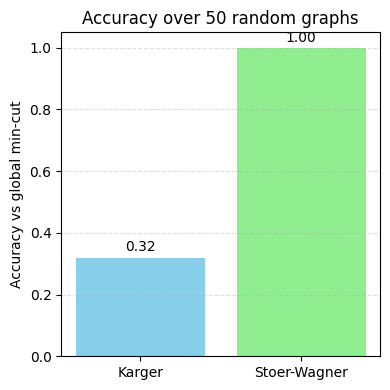

In [163]:
import matplotlib.pyplot as plt

karger_acc = df["karger_correct"].mean()

plt.figure(figsize=(4, 4))
bars = plt.bar(["Karger", "Stoer-Wagner"], [karger_acc, 1.0],
               color=["skyblue", "lightgreen"])
plt.ylim(0, 1.05)
plt.ylabel("Accuracy vs global min-cut")
plt.title("Accuracy over 50 random graphs")

for bar, v in zip(bars, [karger_acc, 1.0]):
    plt.text(bar.get_x() + bar.get_width()/2, v + 0.02, f"{v:.2f}",
             ha="center")

plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


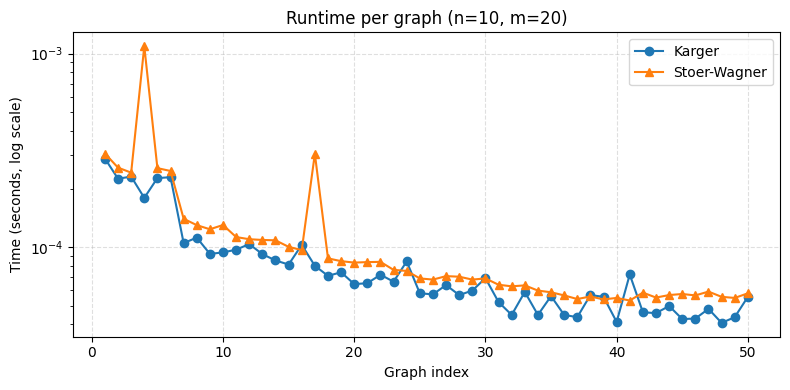

In [164]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
x = df["graph_index"]

plt.plot(x, df["karger_time"], marker="o", linestyle="-", label="Karger")
plt.plot(x, df["sw_time"], marker="^", linestyle="-", label="Stoer-Wagner")

plt.yscale("log")
plt.xlabel("Graph index")
plt.ylabel("Time (seconds, log scale)")
plt.title("Runtime per graph (n=10, m=20)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


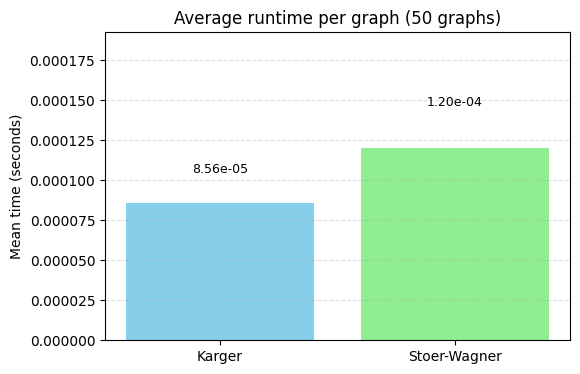

In [165]:
mean_karger_time = df["karger_time"].mean()
mean_sw_time = df["sw_time"].mean()

plt.figure(figsize=(6, 4))
bars = plt.bar(
    ["Karger", "Stoer-Wagner"],
    [mean_karger_time, mean_sw_time],
    color=["skyblue", "lightgreen"]
)

plt.ylabel("Mean time (seconds)")
plt.title("Average runtime per graph (50 graphs)")

for bar, v in zip(bars, [mean_karger_time, mean_sw_time]):
    x = bar.get_x() + bar.get_width()/2
    y = v
    plt.text(
        x,
        y + 0.2 * y,        # 20% above bar height
        f"{v:.2e}",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.ylim(0, max(mean_karger_time, mean_sw_time) * 1.6)  # add headroom
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()
